In [1]:
! jupyter kernelspec list

Available kernels:
  logistic    /Users/chazarey/Library/Jupyter/kernels/logistic
  python3     /Users/chazarey/Desktop/C/DL/DeepLearning/pyenv/share/jupyter/kernels/python3


In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [4]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 20
epsilon_std = 1.0

In [5]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon



In [7]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


In [8]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


In [9]:
# instantiate VAE model
vae = Model(x, x_decoded_mean)



In [10]:
# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)


In [11]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [12]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [13]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [14]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 88us/step - loss: 190.5629 - val_loss: 172.4286
Epoch 2/20
60000/60000 [==============================] - 5s 81us/step - loss: 169.8347 - val_loss: 167.6756
Epoch 3/20
60000/60000 [==============================] - 5s 83us/step - loss: 166.4940 - val_loss: 165.3756
Epoch 4/20
60000/60000 [==============================] - 7s 115us/step - loss: 164.3178 - val_loss: 163.6751
Epoch 5/20
60000/60000 [==============================] - 6s 93us/step - loss: 162.8523 - val_loss: 162.6679
Epoch 6/20
60000/60000 [==============================] - 5s 81us/step - loss: 161.6785 - val_loss: 161.2602
Epoch 7/20
60000/60000 [==============================] - 5s 90us/step - loss: 160.6631 - val_loss: 160.5138
Epoch 8/20
60000/60000 [==============================] - 5s 89us/step - loss: 159.6913 - val_loss: 159.7574
Epoch 9/20
60000/60000 [==============================] - 6s 100us/step - los

In [15]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)


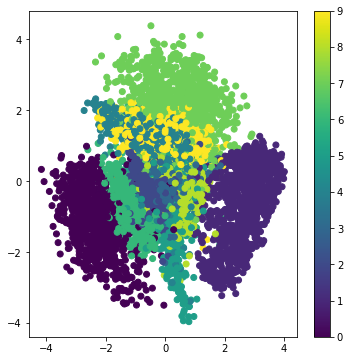

In [16]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()


In [17]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


In [18]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


In [19]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


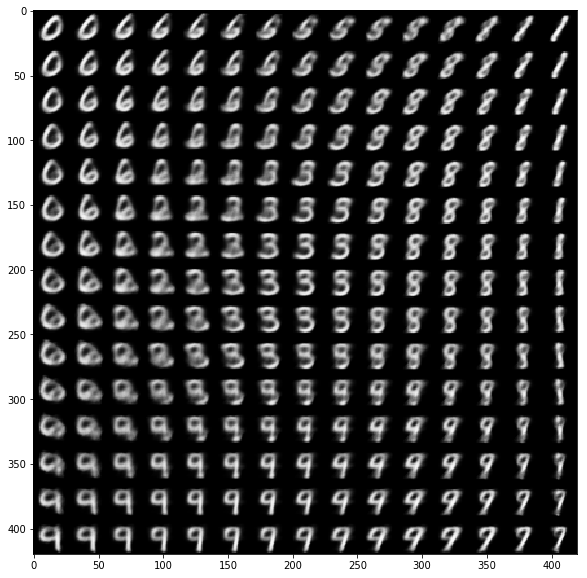

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()